# Imports and modules

In [3]:
!pip install squarify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
import squarify
import re
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem.porter import PorterStemmer
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVR
#from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#path = 'dataset/'
path = '/content/'
wine_150k = pd.read_csv(path + 'winemag-data_first150k.csv',index_col=0)
# wine_130k = pd.read_csv(path + 'winemag-data-130k-v2.csv',index_col=0)
# df = pd.concat([wine_150k,wine_130k],axis=0)
df = wine_150k
print("Number of rows and columns:",df.shape)

df = df.sample(n = 30000)
print("Number of rows and columns:",df.shape)


Number of rows and columns: (150930, 10)
Number of rows and columns: (30000, 10)


# Dataset cleaning


1.   Droppind unwanted columns
2.   Removing duplicates
3.   Filling missing values





In [14]:
#drop columns not needed
df.head()
df = df.drop(['designation','province','region_1','region_2','winery'], axis = 1)

#We will now test for duplictes in the dataset to ensure that we are using unique reviews
df[df.duplicated('description',keep=False)].head()

#We will now remove the dulicates based on the descripton column 
df = df.drop_duplicates('description')
df.head()

,country,description,points,price,variety
6065,France,"Plump, sweet and plush peach flavors fill nose...",92,40.0,Gewürztraminer
6098,Germany,Dusty chalk and herbaceous green notes lend a ...,88,20.0,Riesling
77096,Italy,Romano Dal Forno applies the same stringent qu...,93,129.0,"Corvina, Rondinella, Molinara"
3503,Italy,This elegant expression of Nebbiolo opens with...,90,20.0,Nebbiolo
71464,US,"Soft and creamy, this is consistent with the p...",88,13.0,Chardonnay


In [15]:
#Return a sum count of rows with missing data
df.apply(lambda x: sum(x.isnull()),axis=0) 

#We can see we have 60 entries with country missing, 12821 with price missing and 1 with variety

country           0
description       0
points            0
price          2448
variety           0
dtype: int64

In [16]:
#fill in missing price with mean values
df['price'].fillna(df['price'].mean(), inplace=True)

#Return a sum count of rows with missing data
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        0
description    0
points         0
price          0
variety        0
dtype: int64

In [17]:
#Drop rows with missing/invalid data like country or variety
df.dropna(axis='rows',inplace=True)

#Return a sum count of rows with missing data
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        0
description    0
points         0
price          0
variety        0
dtype: int64

# Cleaning **description** column

Because we will use the description column in our models, we need to clean it, so we:

1.  remomve symbols and digits
2.  change all words to lowercase
3.  remove stop words (most common words, examples me, i, which, the)
4.  stemming words, 





In [18]:
df['description'][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

In [19]:
#Get rid of the less useful parts like symbols and digits
description =  re.sub('[^a-zA-Z]',' ',str(df['description'][0]))
print(description)


#All the words should be in same case so lowercase the words and remove trailing whitespaces
description = description.lower().strip()
print(description)

#convert string to a list of words
description_words = description.split() 

#iterate over each word and include it if it is not stopword 
description_words = [word for word in description_words if not word in stopwords.words('english')]
print(description_words)

#iterate again and stem words
ps = PorterStemmer()
description_words=[ps.stem(word) for word in description_words]
print(description_words)

#Now the description is clean the cleaned list of words can be converted to string and pushed to the dataset
df['description'][0]=' '.join(description_words)
df['description'][0]



This tremendous      varietal wine hails from Oakville and was aged over three years in oak  Juicy red cherry fruit and a compelling hint of caramel greet the palate  framed by elegant  fine tannins and a subtle minty tone in the background  Balanced and rewarding from start to finish  it has years ahead of it to develop further nuance  Enjoy           
this tremendous      varietal wine hails from oakville and was aged over three years in oak  juicy red cherry fruit and a compelling hint of caramel greet the palate  framed by elegant  fine tannins and a subtle minty tone in the background  balanced and rewarding from start to finish  it has years ahead of it to develop further nuance  enjoy
['tremendous', 'varietal', 'wine', 'hails', 'oakville', 'aged', 'three', 'years', 'oak', 'juicy', 'red', 'cherry', 'fruit', 'compelling', 'hint', 'caramel', 'greet', 'palate', 'framed', 'elegant', 'fine', 'tannins', 'subtle', 'minty', 'tone', 'background', 'balanced', 'rewarding', 'start', 'finish'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'tremend variet wine hail oakvil age three year oak juici red cherri fruit compel hint caramel greet palat frame eleg fine tannin subtl minti tone background balanc reward start finish year ahead develop nuanc enjoy'

In [20]:
#Now we iterate over all rows of the dataset and clean each
stopword_list = stopwords.words('english')
ps = PorterStemmer()
for i in range(1,len(df['description'])):
    try:
        description = re.sub('[^a-zA-Z]',' ',str(df['description'][i]))
        description = description.lower().strip()
        description_words = description.split()
        description_words = [word for word in description_words if not word in stopword_list]
        description_words = [ps.stem(word) for word in description_words]
        df['description'][i] = ' '.join(description_words)
    except:
        pass



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
#Displaying 3-4 descriptions after cleaning
for i in range(5):
    try:
        print(str(i+1)+".",df['description'][i],"\n")
    except:
        pass

1. tremend variet wine hail oakvil age three year oak juici red cherri fruit compel hint caramel greet palat frame eleg fine tannin subtl minti tone background balanc reward start finish year ahead develop nuanc enjoy 

2. ripe aroma fig blackberri cassi soften sweeten slather oaki chocol vanilla full layer intens cushion palat rich flavor chocolati black fruit bake spice toasti everlast finish headi ideal balanc drink 

4. spent month new french oak incorpor fruit ponzi aurora abetina madrona vineyard among other aromat dens toasti deftli blend aroma flavor toast cigar box blackberri black cherri coffe graphit tannin polish fine sheen frame finish load dark chocol espresso drink 

5. top wine la b gude name highest point vineyard feet structur densiti consider acid still calm month wood wine develop extra rich concentr produc tari famili formerli ch teau giscour margaux wine made age drink 



Pearson Correlation: (0.42546999691072235, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.473
Model:                            OLS   Adj. R-squared (uncentered):              0.473
Method:                 Least Squares   F-statistic:                          2.465e+04
Date:                Tue, 14 Jan 2020   Prob (F-statistic):                        0.00
Time:                        14:06:01   Log-Likelihood:                     -1.5310e+05
No. Observations:               27461   AIC:                                  3.062e+05
Df Residuals:                   27460   BIC:                                  3.062e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      

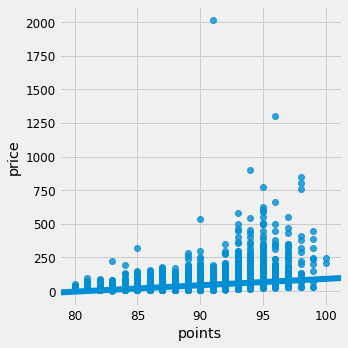

In [22]:
#Correlation between the price of wine and its rating
print("Pearson Correlation:", pearsonr(df.price, df.points))
print(sm.OLS(df.points, df.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=df)

We can see that each point increase in rating, the price goes up.
But there are some samples in the plot which have high price, may be due to low sample of some countriess.

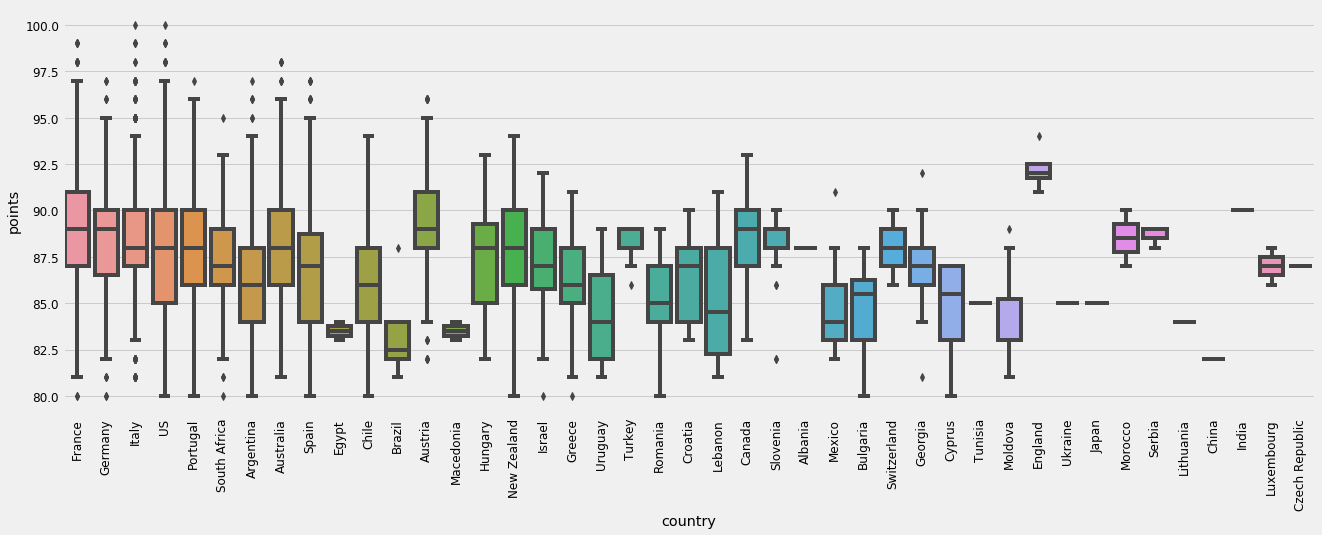

US                11394
Italy              4239
France             3891
Spain              1494
Argentina          1048
Chile              1035
Australia           909
Portugal            908
New Zealand         575
Austria             574
Germany             427
South Africa        410
Greece              178
Israel              112
Hungary              40
Canada               39
Romania              28
Slovenia             22
Croatia              20
Georgia              13
Mexico               13
Turkey               13
Moldova              12
Uruguay              11
Lebanon              10
Bulgaria              8
Brazil                8
Cyprus                4
England               4
Serbia                3
Ukraine               2
Egypt                 2
Morocco               2
Luxembourg            2
Switzerland           2
Macedonia             2
Tunisia               1
China                 1
Albania               1
Lithuania             1
Japan                 1
Czech Republic  

In [23]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=df, ax = ax)
plt.xticks(rotation = 90)
plt.show()



df.country.value_counts()



        country  ...                        variety
6065     France  ...                 Gewürztraminer
6098    Germany  ...                       Riesling
77096     Italy  ...  Corvina, Rondinella, Molinara
3503      Italy  ...                       Nebbiolo
71464        US  ...                     Chardonnay
...         ...  ...                            ...
35173        US  ...                     Pinot Noir
129876    Italy  ...  Corvina, Rondinella, Molinara
61852        US  ...                     Chardonnay
88802    France  ...                       Riesling
65543   Austria  ...                      Red Blend

[27194 rows x 5 columns]


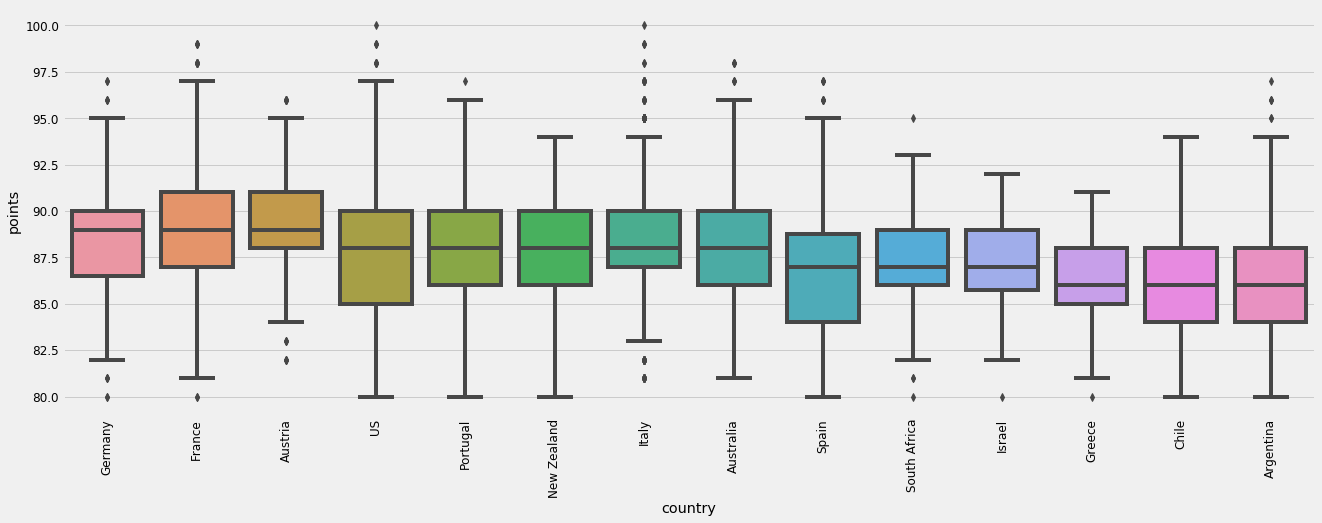

In [24]:
# We will remove countries that have less than 100 observations
country=df.groupby('country').filter(lambda x: len(x) >100)
print(country)
df1 = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
meds = df1.median()
meds.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=meds.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


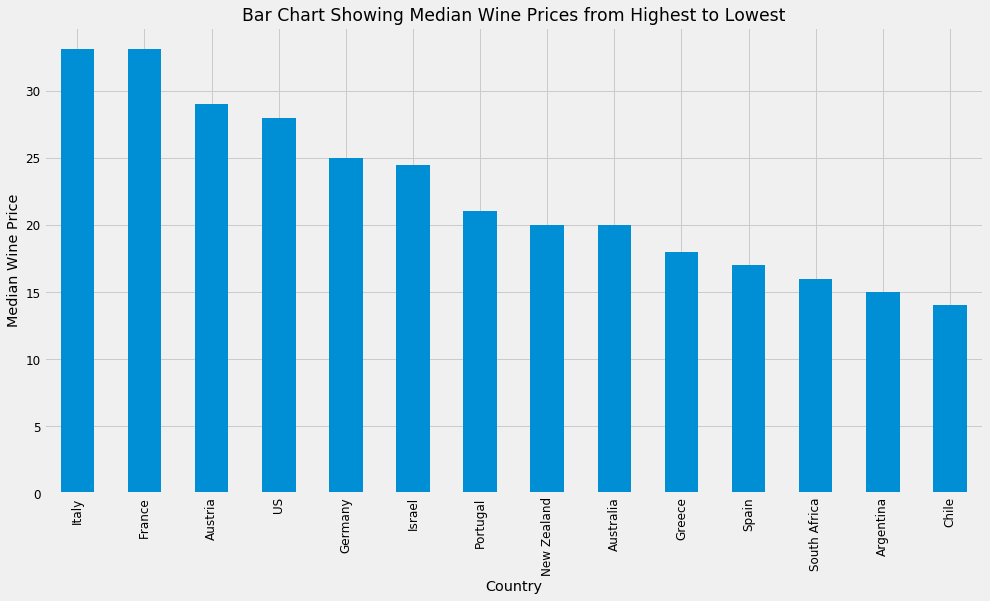

In [25]:
df2 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df2.median()
meds2 = meds2.sort_values(ascending=False)

plt.rcParams['figure.figsize']=15,8 
meds2.plot("bar")
plt.title('Bar Chart Showing Median Wine Prices from Highest to Lowest')
plt.xlabel('Country')
plt.ylabel('Median Wine Price')
plt.show()

# There's a large variety of wines in the dataset. 
>
But it s an exponential decline in the number of samples for each wine, so we will drop samples which contain a wine type with less than 500 observations, because other types of wine can have up to 16000 observations.



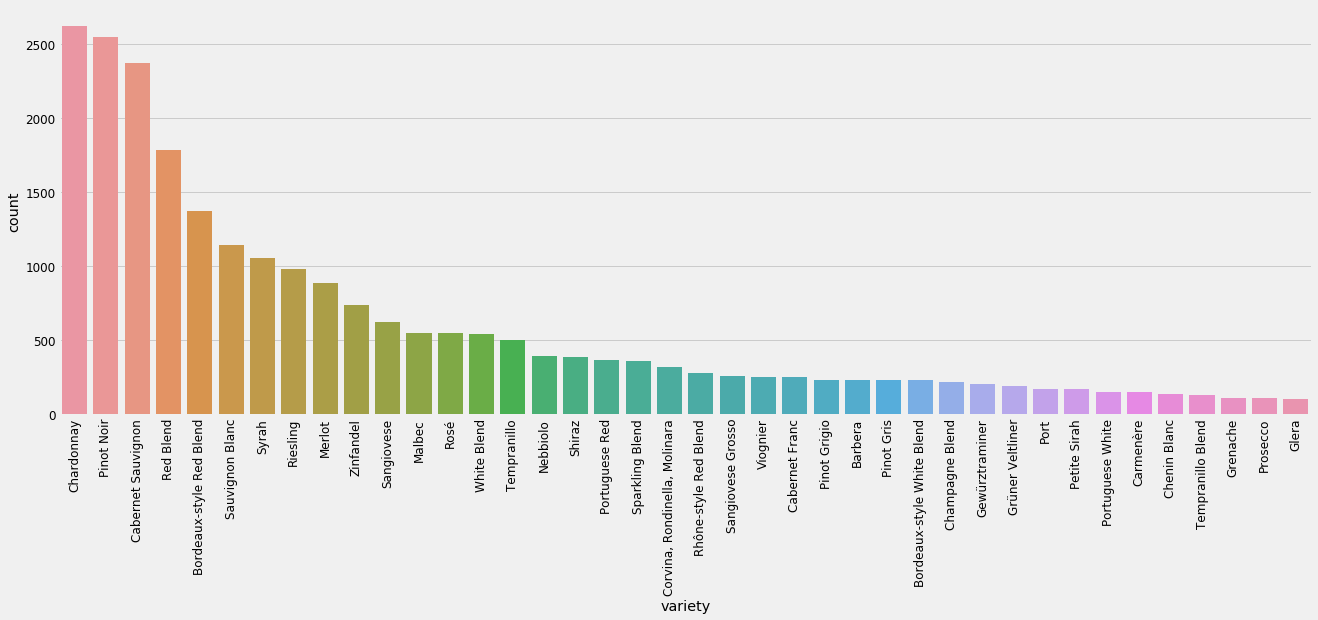

In [26]:
df = df.groupby('variety').filter(lambda x: len(x) >100)
list = df.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=df, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()



In [0]:
df_copy = df

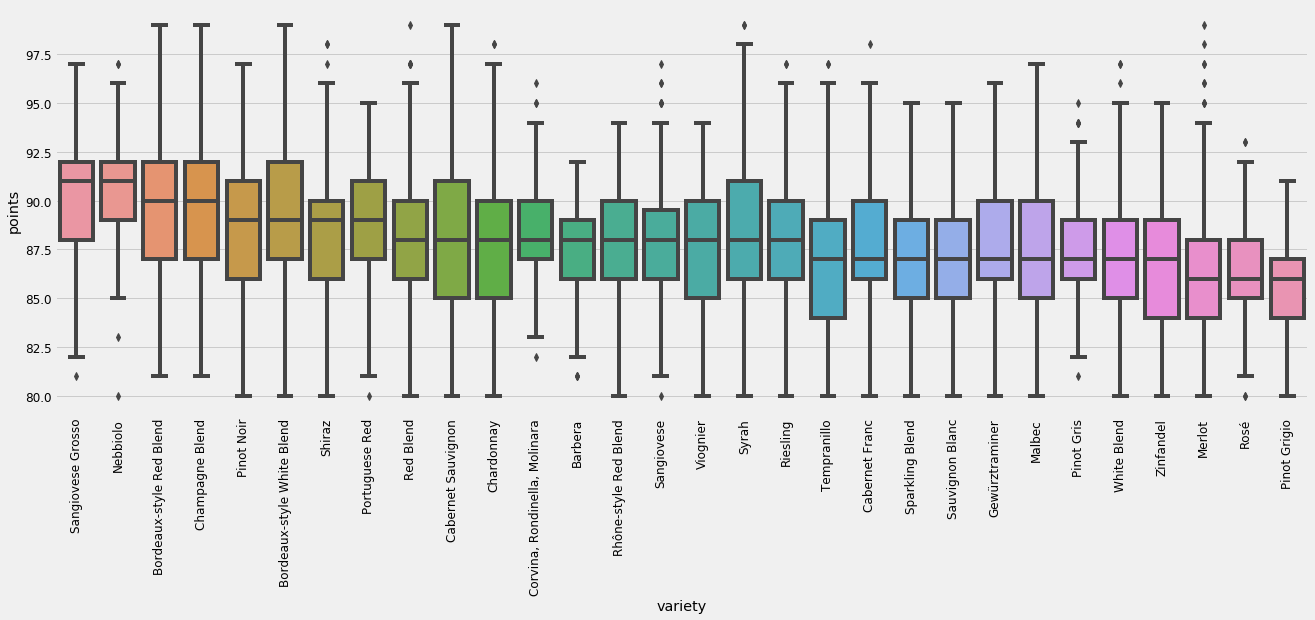

In [28]:
df = df.groupby('variety').filter(lambda x: len(x) > 200)

df3 = pd.DataFrame({col:vals['points'] for col,vals in df.groupby('variety')})
meds3 = df3.median()
meds3.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=df, order=meds3.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


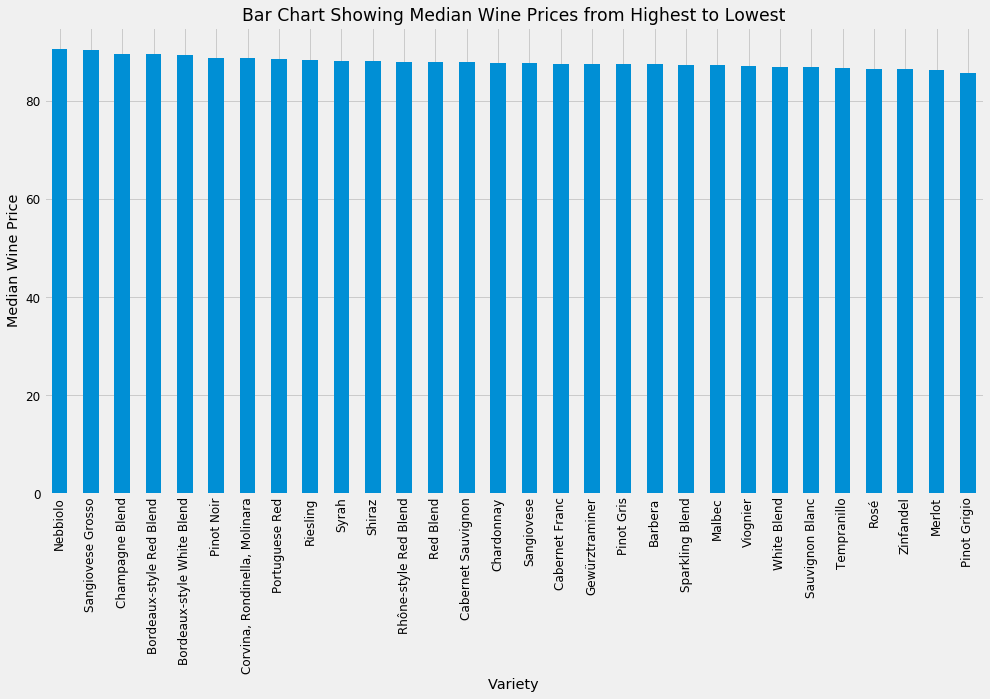

In [29]:
df4 = pd.DataFrame({col:vals['points'] for col,vals in df.groupby('variety')})
mean1 = df4.mean()
mean1 = mean1.sort_values(ascending=False)

plt.rcParams['figure.figsize']=15,8 
mean1.plot("bar")
plt.title('Bar Chart Showing Median Wine Prices from Highest to Lowest')
plt.xlabel('Variety')
plt.ylabel('Median Wine Price')
plt.show()



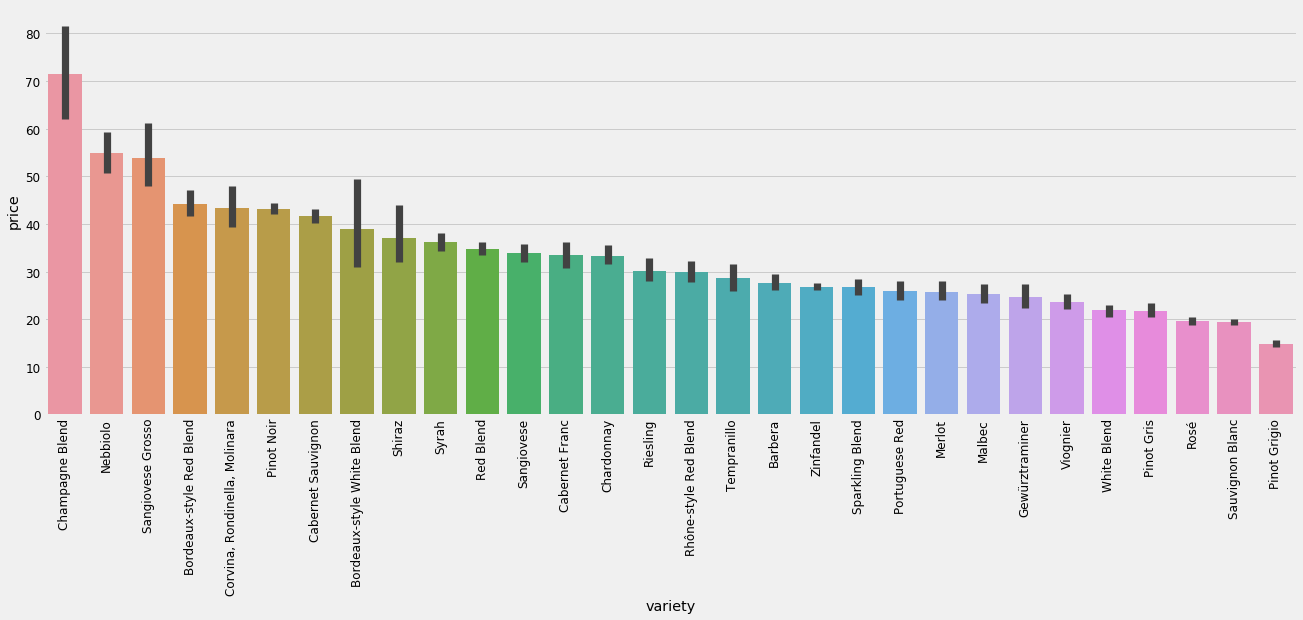

In [30]:
#We will now test the variations in price
df5 = pd.DataFrame({col:vals['price'] for col,vals in df.groupby('variety')})
mean2 = df5.mean()
mean2.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=df, order=mean2.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()



# Logistic Regression

In [31]:
X = df.drop(['country','points', 'variety'], axis = 1)
y = df.variety

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16884, 2) (5628, 2) (16884,) (5628,)


In [32]:
#Sometime the variety of wines appears in the description, so we need to remove these words
wine =df.variety.unique().tolist()
wine.sort()
wine

#Split wine varieties with space and make new list
output = set()
for x in df.variety:
    x = x.lower()
    x = x.split()
    for y in x:
        output.add(y)

variety_list =sorted(output)
variety_list



['barbera',
 'blanc',
 'blend',
 'bordeaux-style',
 'cabernet',
 'champagne',
 'chardonnay',
 'corvina,',
 'franc',
 'gewürztraminer',
 'grigio',
 'gris',
 'grosso',
 'malbec',
 'merlot',
 'molinara',
 'nebbiolo',
 'noir',
 'pinot',
 'portuguese',
 'red',
 'rhône-style',
 'riesling',
 'rondinella,',
 'rosé',
 'sangiovese',
 'sauvignon',
 'shiraz',
 'sparkling',
 'syrah',
 'tempranillo',
 'viognier',
 'white',
 'zinfandel']

In [0]:
extras = ['',' ',""," ",'.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(variety_list)
stop.update(extras)

In [34]:
vect = CountVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train.description)
price = X_train.price.values[:,None]
X_train_dtm = hstack((X_train_dtm, price))

X_test_dtm = vect.transform(X_test.description)
price_test = X_test.price.values[:,None]
X_test_dtm = hstack((X_test_dtm, price_test))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bordeaux', 'corvina', 'rhône', 'rondinella', 'style'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [35]:
models = {}
for z in wine:
    model = LogisticRegression()
    y = y_train == z
    model.fit(X_train_dtm, y)
    models[z] = model

testing_probs = pd.DataFrame(columns = wine)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [36]:
for variety in wine:
    testing_probs[variety] = models[variety].predict_proba(X_test_dtm)[:,1]
    
predicted_wine = testing_probs.idxmax(axis=1)

comparison = pd.DataFrame({'actual':y_test.values, 'predicted':predicted_wine.values})   
# comparison = pd.DataFrame({'actual':'Malbec', 'predicted':predicted_wine.values})   

print('Accuracy Score:',accuracy_score(comparison.actual, comparison.predicted)*100,"%")
comparison

Accuracy Score: 53.35820895522389 %


,actual,predicted
0,Zinfandel,Zinfandel
1,Red Blend,Bordeaux-style Red Blend
2,Sangiovese,Cabernet Sauvignon
3,Barbera,Merlot
4,Sparkling Blend,Sparkling Blend
...,...,...
5623,Nebbiolo,Cabernet Sauvignon
5624,Pinot Noir,Pinot Noir
5625,Pinot Noir,Pinot Noir
5626,Malbec,Pinot Noir


In [37]:
filtered = df.groupby('variety').filter(lambda x: len(x) >= 500) 
filtered
#taking only the highest occuring to reduce size and keeping distribution in mind.

,country,description,points,price,variety
6098,Germany,dusti chalk herbac green note lend savori dri ...,88,20.0,Riesling
71464,US,"Soft and creamy, this is consistent with the p...",88,13.0,Chardonnay
31790,South Africa,Sweet oak and cocoa nib tones add depth to the...,88,15.0,Red Blend
81349,US,"A smooth, crisp Syrah-based Rhône blend, and a...",85,12.0,Red Blend
100493,France,"This is dry, but not quite bone dry. The richn...",91,49.0,Pinot Noir
...,...,...,...,...,...
101397,US,Malbec is difficult to make well on its own in...,90,35.0,Malbec
35173,US,The aromas on this bottling from just outside ...,85,31.0,Pinot Noir
61852,US,"Here's a good, rich and super-drinkable Chardo...",88,24.0,Chardonnay
88802,France,"A fascinating nose, with grapefruit, kiwi, cit...",88,30.0,Riesling


In [38]:
#Making a new column that is encoded version of variety
filtered['variety_id'] = filtered['variety'].factorize()[0]
category_id_df = filtered[['variety', 'variety_id']].drop_duplicates().sort_values('variety_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['variety_id', 'variety']].values)

filtered.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,country,description,points,price,variety,variety_id
6098,Germany,dusti chalk herbac green note lend savori dri ...,88,20.0,Riesling,0
71464,US,"Soft and creamy, this is consistent with the p...",88,13.0,Chardonnay,1
31790,South Africa,Sweet oak and cocoa nib tones add depth to the...,88,15.0,Red Blend,2
81349,US,"A smooth, crisp Syrah-based Rhône blend, and a...",85,12.0,Red Blend,2
100493,France,"This is dry, but not quite bone dry. The richn...",91,49.0,Pinot Noir,3


In [39]:
print(filtered.shape)
filtered = filtered[0:30000]
print(filtered)

(18272, 6)
             country  ... variety_id
6098         Germany  ...          0
71464             US  ...          1
31790   South Africa  ...          2
81349             US  ...          2
100493        France  ...          3
...              ...  ...        ...
101397            US  ...         12
35173             US  ...          3
61852             US  ...          1
88802         France  ...          0
65543        Austria  ...          2

[18272 rows x 6 columns]


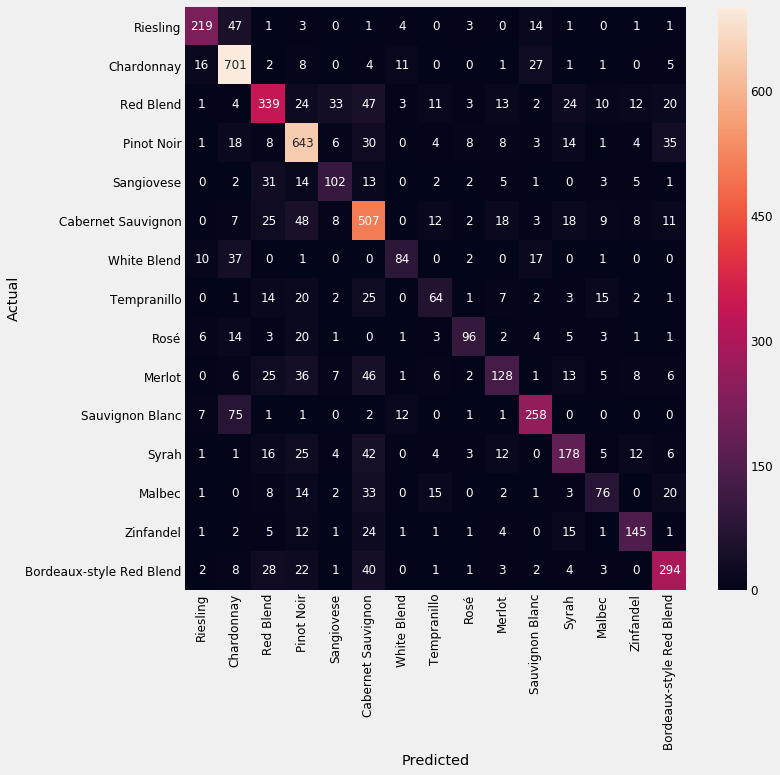

In [40]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), stop_words='english') 

features = tfidf.fit_transform(filtered.description).toarray() #Removing Stop words from descriptions 
labels = filtered.variety_id #Varity Numberical values saved as labels

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, filtered.index, test_size=0.30, random_state=0) #70/30 Split
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [41]:
print('Accuracy Score:',accuracy_score(y_test, y_pred)*100,"%")


Accuracy Score: 69.93797883983947 %


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(0.01,100,10)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train,y_train)
print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

bestlinearSVC = linearSVC.best_estimator_
bestlinearSVC.fit(X_train,y_train)
bestlinearSVC.coef_ = bestlinearSVC.named_steps['SVC'].coef_
bestlinearSVC.score(X_train,y_train)

y_pred = bestlinearSVC.predict(X_test)
print('Accuracy Score:',accuracy_score(y_test, y_pred)*100,"%")
